In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from utils.helpers import int2atom, atom2int
import seaborn as sn
from tqdm import tqdm
#import dask.dataframe as dd
#import dask

In [2]:
%matplotlib notebook

In [43]:
conn = sqlite3.connect("/work1/s180213/results_qm9.db")
models = conn.execute("select distinct model_id from models where model_name_short not like '%(%'").fetchall()


results_mask = pd.DataFrame()
results_length = pd.DataFrame()

for model in tqdm(models):
    df = pd.read_sql_query(f"""select
                             case
                                 when target=prediction then 1
                                 else 0
                             end as accuracy,
                             case 
                                when target=prediction then 1 
                                when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then 1
                                when (target=2 or target=6) and (prediction=2 or target=6) then 1
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then 1
                              
                                else 0
                           end as accuracy_octet,

                    case 
                        when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then target
                                when (target=2 or target=6) and (prediction=2 or target=6) then target
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then target
                        
                        
                        else prediction
                    end as prediction_octet,
                    prediction,
                    target, cross_entropy,num_masks, predictions.model_id, model_name_short, length 
                          from predictions, models, molecules
                          where predictions.model_id=models.model_id 
                          and predictions.molecule_id=molecules.molecule_id
                          and predictions.model_id ='{model[0]}'
                           """, conn)

    f1_mask = df \
                    .groupby(['num_masks','model_id', 'model_name_short']) \
                    .apply(lambda df:pd.Series({
                        'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                        'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                        'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                        'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                        }
                        )
                     ) \
                    #.groupby(['model_name_short','num_masks']) \
                    #.agg(['mean','std'])

    f1_length = df[df['num_masks']==1]\
                    .groupby(['model_id', 'model_name_short','length']) \
                    .apply(lambda df:pd.Series({
                        'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                        'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                        'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                        'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                        }
                        )
                     ) \
                    #.groupby(['model_name_short', 'length'])\
                    #.agg(['mean','std'])

    model_df = df.groupby(['num_masks','model_id', 'model_name_short']).mean()
    model_df['pp'] = np.exp(model_df['cross_entropy'])
    #model_df = model_df.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])[['accuracy','accuracy_octet','pp']]
    #model_df

    result_mask = pd.concat([f1_mask, model_df],axis=1)
    results_mask = results_mask.append(result_mask)
    results_length = results_length.append(f1_length)


100%|██████████| 62/62 [23:02<00:00, 17.48s/it]

In [44]:
results_mask2 = results_mask.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])[['accuracy_octet','f1 micro (octet)','f1 macro (octet)','pp']]
results_mask2.reset_index()[results_mask2.reset_index().num_masks==1]

model_name_short num_masks accuracy_octet           f1 micro (octet)  \
                                             mean       std             mean   
0           Bag-of-atoms         1       0.657674  0.044765         0.657674   
7       Bag-of-atoms_old         1       0.633181  0.008900         0.633181   
14      Bag-of-neighbors         1       0.906673  0.000026         0.906673   
21  Bag-of-neighbors_old         1       0.937759  0.002667         0.937759   
28             OctetRule         1       1.000000       NaN         1.000000   
35               Unigram         1       0.473210       NaN         0.473210   
42           transformer         1       0.997288  0.000649         0.997288   
49      transformer bond         1       0.999986  0.000022         0.999986   

             f1 macro (octet)                  pp            
         std             mean       std      mean       std  
0   0.044765         0.442965  0.049159  3.310356  0.477642  
7   0.008900         0.455725  0.008583  3.477910  0.641446  
14  0.000026         0.771843  0.000022  1.281443  0.004071  
21  0.002667         0.879707  0.006102  1.159262  0.004340  
28       NaN         1.000000       NaN  1.002159       NaN  
35       NaN         0.328475       NaN  3.103823       NaN  
42  0.000649         0.934430  0.041962  1.009329  0.001683  
49  0.000022         0.999966  0.000056  1.002296  0.000678

<IPython.core.display.Javascript object>


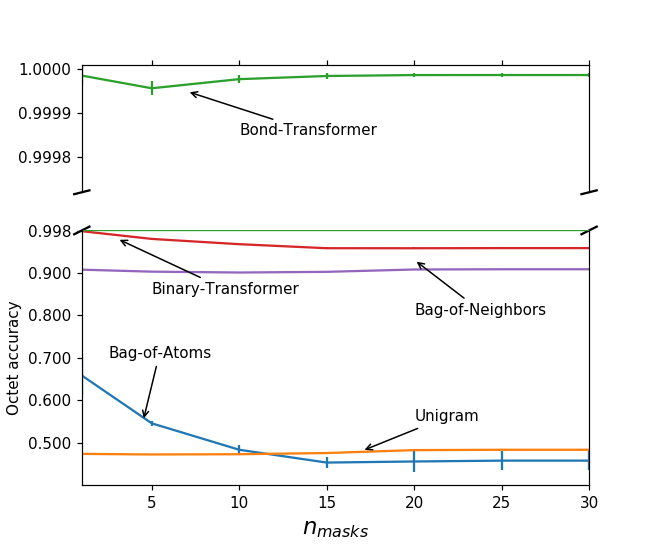

In [49]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet accuracy')



colors = {'Unigram':'C1', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C4',
         'transformer':'C3',
         'transformer bond':'C2',
         'OctetRule':'C5',
         'Bag-of-atoms_old':'W',
         'Bag-of-neighbors_old':'W'}

for key, group in results_mask2['accuracy_octet'].reset_index().groupby('model_name_short'):
    if 'Octet' not in key and 'old' not in key:
        group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

        group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.99972, 1.00001])
ax2.set_ylim([0.4, 0.999])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.998])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)

ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(4.5,0.55), xytext=(2.5,0.7),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(20,0.93), xytext=(20,0.80),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})

plt.savefig('octet_accuracy_vs_nmask_qm9.pdf')

In [45]:
results_length2 = results_length.groupby(['model_name_short', 'length']).agg(['mean','std'])
results_length2

f1 micro            f1 macro            \
                             mean       std      mean       std   
model_name_short length                                           
Bag-of-atoms     5       0.100000  0.253859  0.077778  0.166048   
                 6       0.280000  0.091894  0.217904  0.139404   
                 7       0.200000  0.000000  0.206111  0.061262   
                 8       0.205714  0.098791  0.192647  0.056957   
                 9       0.294286  0.073285  0.221541  0.055688   
                 10      0.288529  0.032647  0.168951  0.028159   
                 11      0.281517  0.014163  0.144899  0.012292   
                 12      0.354955  0.019665  0.163057  0.018184   
                 13      0.399580  0.021974  0.176082  0.019326   
                 14      0.472193  0.030800  0.249552  0.018806   
                 15      0.518409  0.050553  0.263924  0.025260   
                 16      0.565520  0.067645  0.287942  0.052063   
                 17      0.633971  0.055584  0.327540  0.042467   
                 18      0.714873  0.054113  0.373456  0.034132   
                 19      0.797008  0.041129  0.411623  0.023489   
                 20      0.840411  0.027820  0.437662  0.014638   
                 21      0.849402  0.038338  0.432387  0.019489   
                 22      0.797215  0.042805  0.408380  0.021124   
                 23      0.779481  0.054786  0.393428  0.027110   
                 24      0.342857  0.000000  0.170213  0.000000   
                 25      0.406667  0.000000  0.192733  0.000000   
                 27      0.300000  0.000000  0.230769  0.000000   
Bag-of-atoms_old 5       0.080000  0.252982  0.044444  0.140546   
                 6       0.210000  0.073786  0.096609  0.056557   
                 7       0.200000  0.000000  0.111111  0.000000   
                 8       0.171429  0.038095  0.103357  0.018432   
                 9       0.374286  0.011043  0.253900  0.014555   
                 10      0.325294  0.017820  0.178531  0.010815   
                 11      0.295310  0.012172  0.152678  0.009981   
                 12      0.352853  0.008438  0.161013  0.006991   
...                           ...       ...       ...       ...   
transformer      19      0.999848  0.000129  0.999090  0.000839   
                 20      1.000000  0.000000  1.000000  0.000000   
                 21      0.999937  0.000081  0.998830  0.001510   
                 22      1.000000  0.000000  1.000000  0.000000   
                 23      1.000000  0.000000  1.000000  0.000000   
                 24      1.000000  0.000000  1.000000  0.000000   
                 25      1.000000  0.000000  1.000000  0.000000   
                 27      1.000000  0.000000  1.000000  0.000000   
transformer bond 5       0.900000  0.141421  0.788889  0.274424   
                 6       0.960000  0.069921  0.902500  0.168511   
                 7       1.000000  0.000000  1.000000  0.000000   
                 8       0.982857  0.019977  0.864793  0.142630   
                 9       0.985714  0.017532  0.868790  0.113305   
                 10      0.993235  0.002790  0.796301  0.001967   
                 11      0.992966  0.002716  0.796754  0.001285   
                 12      0.998018  0.002266  0.799316  0.000789   
                 13      0.999339  0.000580  0.799792  0.000183   
                 14      0.999947  0.000169  0.979986  0.063291   
                 15      0.999989  0.000035  0.979997  0.063254   
                 16      0.999955  0.000094  0.959990  0.084349   
                 17      1.000000  0.000000  1.000000  0.000000   
                 18      1.000000  0.000000  1.000000  0.000000   
                 19      1.000000  0.000000  1.000000  0.000000   
                 20      1.000000  0.000000  1.000000  0.000000   
                 21      1.000000  0.000000  1.000000  0.000000   
                 22      1.000000  0.000000  1.000000  0.000000   
     

<IPython.core.display.Javascript object>


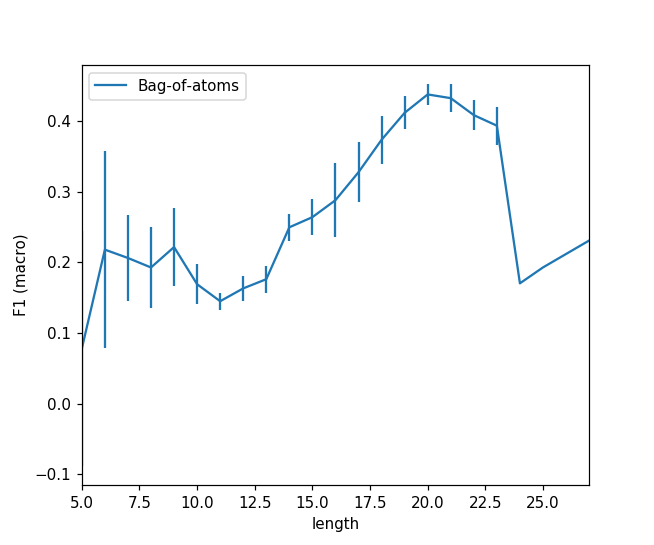

KeyError: 'Bag-of-atoms_old'

In [46]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('F1 (macro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length2['f1 macro'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax, color=colors[key])
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
#ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

#ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
#ax.set_ylabel('Molecule count')
#ax.set_yscale('log')
#ax.set_yticks([1e2,1e4,1e6])
#ax2.set_xlabel('Number of atoms')
#plt.savefig('f1_micro_vs_length_5.pdf')
plt.savefig('sample_f1_macro_vs_length.pdf')

In [18]:
df = pd.read_sql_query(f"""select
                             case
                                 when target=prediction then 1
                                 else 0
                             end as accuracy,
                             case 
                                when target=prediction then 1 
                                when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then 1
                                when (target=2 or target=6) and (prediction=2 or target=6) then 1
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then 1
                              
                                else 0
                           end as accuracy_octet,

                    case 
                        when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then target
                                when (target=2 or target=6) and (prediction=2 or target=6) then target
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then target
                        
                        
                        else prediction
                    end as prediction_octet,
                    prediction,
                    target, cross_entropy,num_masks, predictions.model_id, model_name_short, length 
                          from predictions, models, molecules
                          where predictions.model_id=models.model_id 
                          and predictions.molecule_id=molecules.molecule_id
                          and predictions.model_id =41
                           """, conn)


<IPython.core.display.Javascript object>


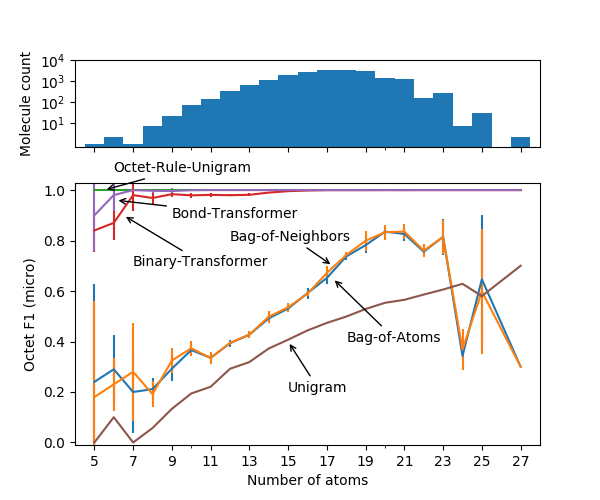

In [93]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax2.set_ylabel('Octet F1 (micro)')
ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Atoms', xy=(17.3,0.65), xytext=(18,0.4),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(17.3,0.7), xytext=(12,0.8),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(6.5,0.9), xytext=(7,0.7),arrowprops={'arrowstyle':'->'})
ax2.annotate('Octet-Rule-Unigram', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bond-Transformer', xy=(6.1,0.96), xytext=(9,0.89),arrowprops={'arrowstyle':'->'})

for key, group in results_df_length2['f1'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax2)
    
ax2.set_xticks(np.arange(5,28, 2.0))
ax2.set_xlim([4, 28])
ax2.set_ylim([-0.01,1.03])
ax2.get_legend().remove()

ax.hist(df[(df['num_masks']==1)&(df['model_id']==33)]['length'], density=False, bins=np.arange(4,28)+0.5, weights=np.ones(99030,)*0.2)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e1,1e2,1e3,1e4])
ax2.set_xlabel('Number of atoms')
plt.savefig('f1_micro_vs_length.pdf')

<IPython.core.display.Javascript object>


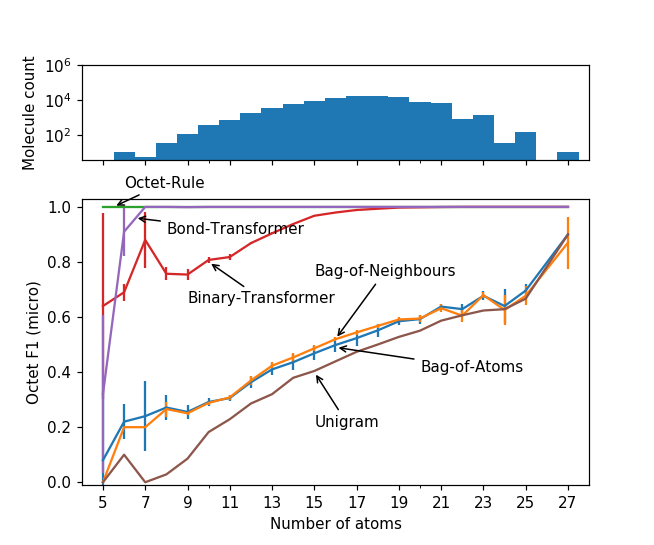

In [17]:
results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax2.set_ylabel('Octet F1 (micro)')
ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_df['f1'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax2)
    
ax2.set_xticks(np.arange(5,28, 2.0))
ax2.set_xlim([4, 28])
ax2.set_ylim([-0.01,1.03])
ax2.get_legend().remove()

ax.hist(df[(df['num_masks']==5) & (df['model_name']=='Unigram')]['length'], density=False, bins=np.arange(5,28)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e2,1e4,1e6])
ax2.set_xlabel('Number of atoms')
plt.savefig('f1_micro_vs_length_5.pdf')

In [9]:
df.head()

,prediction,target,num_masks,model_id,model_name_short,length


# per mask

In [4]:
model_df = df.groupby(['num_masks','model_name', 'model_name_short']).mean()
model_df['pp'] = np.exp(model_df['cross_entropy'])
results_df = model_df.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])
results_df

accuracy_octet            accuracy            \
                                         mean       std      mean       std   
model_name_short     num_masks                                                
Bag-of-Atoms         25              0.453168  0.010055  0.453168  0.010055   
Bag-of-Neighbours    25              0.446338  0.021643  0.446338  0.021643   
OctetRule            25              1.000000       NaN  0.999933       NaN   
Transformer Binary   25              0.957866  0.001410  0.957800  0.001410   
Transformer Bondtype 25              0.999987  0.000005  0.999896  0.000026   
Unigram              25              0.482877       NaN  0.482810       NaN   

                               prediction              target       \
                                     mean       std      mean  std   
model_name_short     num_masks                                       
Bag-of-Atoms         25          0.476979  0.078996  0.734414  0.0   
Bag-of-Neighbours    25          0.521017  0.151624  0.734414  0.0   
OctetRule            25          0.734414       NaN  0.734414  NaN   
Transformer Binary   25          0.710224  0.005521  0.734414  0.0   
Transformer Bondtype 25          0.734397  0.000013  0.734414  0.0   
Unigram              25          0.000269       NaN  0.734414  NaN   

                               cross_entropy               length       \
                                        mean       std       mean  std   
model_name_short     num_masks                                           
Bag-of-Atoms         25             1.092930  0.002391  17.619038  0.0   
Bag-of-Neighbours    25             1.094560  0.004627  17.619038  0.0   
OctetRule            25             0.024625       NaN  17.619038  NaN   
Transformer Binary   25             0.089264  0.003226  17.619038  0.0   
Transformer Bondtype 25             0.001759  0.000541  17.619038  0.0   
Unigram              25             1.109412       NaN  17.619038  NaN   

                                      pp            
                                    mean       std  
model_name_short     num_masks                      
Bag-of-Atoms         25         2.983008  0.007136  
Bag-of-Neighbours    25         2.987898  0.013872  
OctetRule            25         1.024930       NaN  
Transformer Binary   25         1.093374  0.003528  
Transformer Bondtype 25         1.001761  0.000542  
Unigram              25         3.032574       NaN

<IPython.core.display.Javascript object>


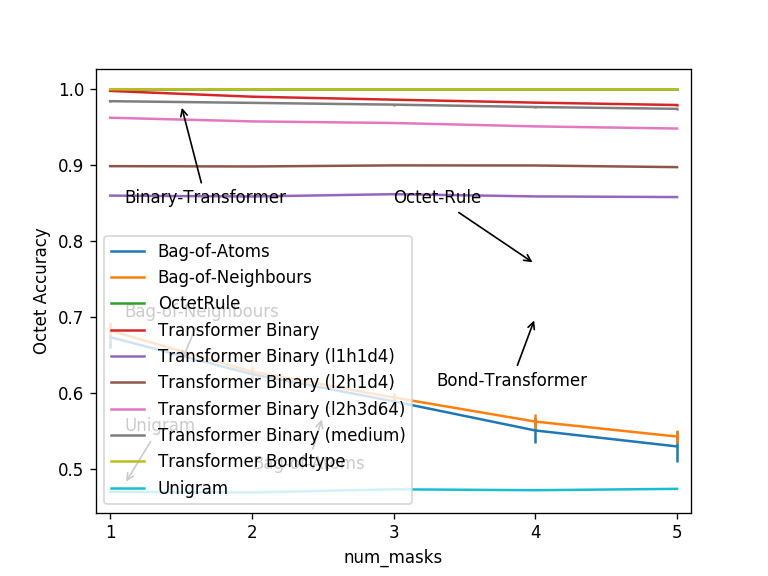

(0.9, 5.1)

In [8]:
fig, ax = plt.subplots()
plt.ylabel('Octet Accuracy')
plt.annotate('Unigram', xy=(1.1,0.48), xytext=(1.1,0.55),arrowprops={'arrowstyle':'->'})
plt.annotate('Bag-of-Atoms', xy=(2.5,0.57), xytext=(2,0.5),arrowprops={'arrowstyle':'->'})
plt.annotate('Bag-of-Neighbours', xy=(1.5,0.64), xytext=(1.1,0.7),arrowprops={'arrowstyle':'->'})
plt.annotate('Binary-Transformer', xy=(1.5,0.98), xytext=(1.1,0.85),arrowprops={'arrowstyle':'->'})
plt.annotate('Octet-Rule', xy=(4,0.77), xytext=(3,0.85),arrowprops={'arrowstyle':'->'})
plt.annotate('Bond-Transformer', xy=(4,0.7), xytext=(3.3,0.61),arrowprops={'arrowstyle':'->'})
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes

#axins = zoomed_inset_axes(ax, 40, loc=9)
#axins = inset_axes(ax, width=2,height=0.5, loc=5)
#axins.set_ylim([0.9998,1.0001])
#axins.set_xlim([1,5])
#plt.xticks(visible=False)
for key, group in results_df['accuracy_octet'].reset_index().groupby('model_name_short'):

    
    #axins.plot(group['num_masks'], group['mean'])
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

#mark_inset(ax, axins, loc1=1, loc2=2, ec="0.5")
ax.set_xticks(np.arange(1,6, 1.0))
ax.set_xlim([0.9, 5.1])
#ax.get_legend().remove()


<IPython.core.display.Javascript object>


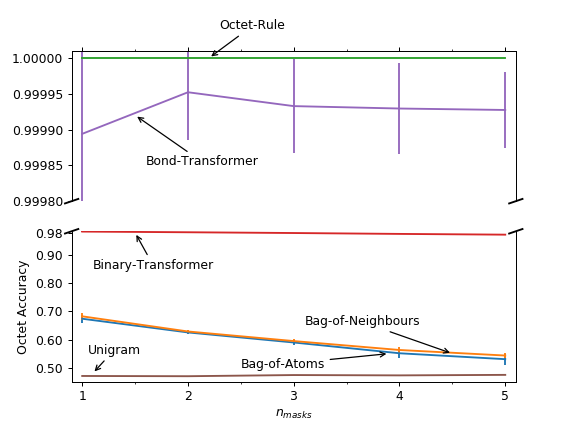

In [18]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True)
plt.ylabel('Octet Accuracy')
ax2.annotate('Unigram', xy=(1.1,0.48), xytext=(1.05,0.55),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Atoms', xy=(3.9,0.55), xytext=(2.5,0.5),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbours', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(1.5,0.98), xytext=(1.1,0.85),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule', xy=(2.2,1), xytext=(2.3,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(1.5,0.99992), xytext=(1.6,0.99985),arrowprops={'arrowstyle':'->'})

for key, group in results_df['accuracy_octet'].reset_index().groupby('model_name_short'):

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2)

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.9998, 1.00001])
ax2.set_ylim([0.45, 0.985])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.set_xlim([0.9, 5.1])
ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.98])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$')
plt.savefig('accuracy_vs_nmask.pdf')

<IPython.core.display.Javascript object>


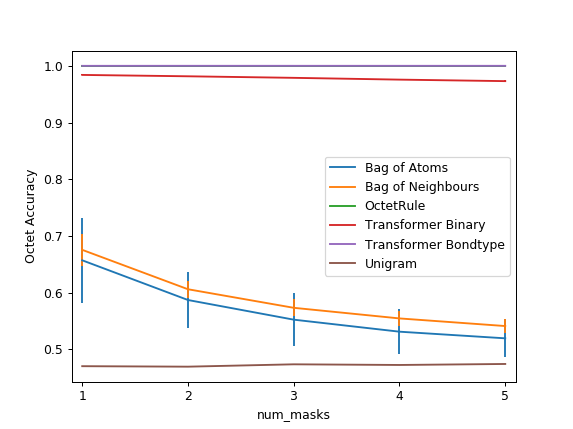

(0.9, 5.1)

In [8]:
fig, ax = plt.subplots()
plt.ylabel('Octet Accuracy')

for key, group in results_df['accuracy_octet'].reset_index().groupby('model_name_short'):
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)
plt.xticks(np.arange(1,6, 1.0))
plt.xlim([0.9, 5.1])

<IPython.core.display.Javascript object>


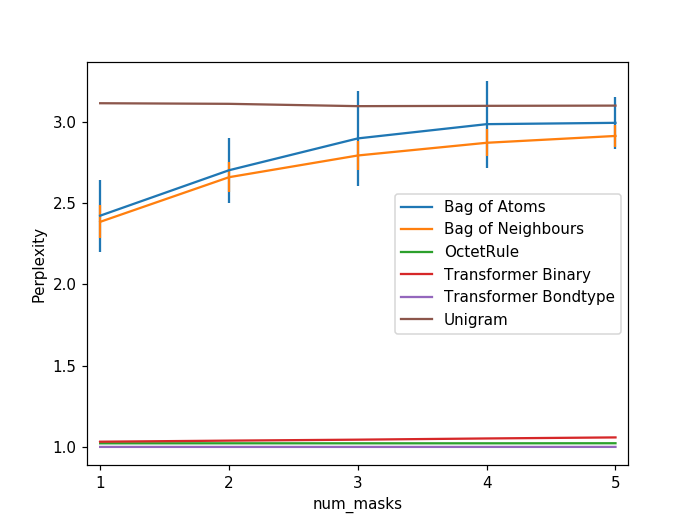

(0.9, 5.1)

In [8]:
fig, ax = plt.subplots()
plt.ylabel('Perplexity')

for key, group in results_df['pp'].reset_index().groupby('model_name_short'):
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)
    
plt.xticks(np.arange(1,6, 1.0))
plt.xlim([0.9, 5.1])

# per length

<IPython.core.display.Javascript object>


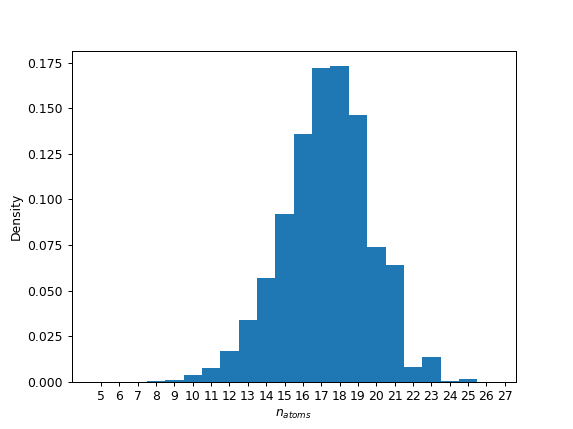

Text(0, 0.5, 'Density')

In [14]:
plt.figure()
df[df['num_masks']==1]['length'].hist(bins=np.arange(5,28)-0.5, density=True, grid=False)
plt.xticks(np.arange(5,28))
plt.xlabel('$n_{atoms}$')
plt.ylabel('Density')

In [65]:
import matplotlib.pyplot import xticks
plt.xticks=xticks

In [68]:
xticks

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27])

In [9]:
model_df = df[df['num_masks']==1].groupby(['model_name', 'model_name_short','length']).mean()
model_df['pp'] = np.exp(model_df['cross_entropy'])
results_df = model_df.groupby(['model_name_short','length']).agg(['mean','std'])
results_df

accuracy_octet            accuracy            \
                                      mean       std      mean       std   
model_name_short     length                                                
Bag of Atoms         5            0.000000  0.000000  0.000000  0.000000   
                     6            0.050000  0.158114  0.050000  0.158114   
                     7            0.100000  0.316228  0.100000  0.316228   
                     8            0.157143  0.157215  0.157143  0.157215   
                     9            0.304762  0.110429  0.280952  0.106361   
                     10           0.316176  0.093588  0.304412  0.092762   
                     11           0.313793  0.039983  0.313793  0.039983   
                     12           0.390691  0.057824  0.390390  0.058024   
                     13           0.426126  0.050735  0.425976  0.050603   
                     14           0.489305  0.050024  0.489305  0.050024   
                     15           0.525891  0.055861  0.525891  0.055861   
                     16           0.606347  0.074189  0.606347  0.074189   
                     17           0.653312  0.080733  0.653312  0.080733   
                     18           0.724175  0.091875  0.724175  0.091875   
                     19           0.743504  0.093796  0.743504  0.093796   
                     20           0.784716  0.084519  0.784716  0.084519   
                     21           0.809764  0.092566  0.809764  0.092566   
                     22           0.739241  0.091124  0.739241  0.091124   
                     23           0.786296  0.131978  0.786296  0.131978   
                     24           0.542857  0.162185  0.542857  0.162185   
                     25           0.626667  0.238203  0.626667  0.238203   
                     27           0.500000  0.000000  0.500000  0.000000   
Bag of Neighbours    5            0.200000  0.421637  0.200000  0.421637   
                     6            0.000000  0.000000  0.000000  0.000000   
                     7            0.100000  0.316228  0.100000  0.316228   
                     8            0.157143  0.157215  0.157143  0.157215   
                     9            0.261905  0.108240  0.247619  0.102378   
                     10           0.304412  0.055912  0.291176  0.057918   
                     11           0.308276  0.048771  0.306897  0.048576   
                     12           0.382883  0.045986  0.380480  0.044924   
...                                    ...       ...       ...       ...   
Transformer Bondtype 19           1.000000  0.000000  1.000000  0.000000   
                     20           1.000000  0.000000  1.000000  0.000000   
                     21           1.000000  0.000000  1.000000  0.000000   
                     22           1.000000  0.000000  1.000000  0.000000   
                     23           1.000000  0.000000  1.000000  0.000000   
                     24           1.000000  0.000000  1.000000  0.000000   
                     25           1.000000  0.000000  1.000000  0.000000   
                     27           1.000000  0.000000  1.000000  0.000000   
Unigram              5            0.000000       NaN  0.000000       NaN   
                     6            0.000000       NaN  0.000000       NaN   
                     7            0.000000       NaN  0.000000       NaN   
                     8            0.000000       NaN  0.000000       NaN   
                     9            0.095238       NaN  0.047619       NaN   
                     10           0.117647       NaN  0.102941       NaN   
                     11           0.234483       NaN  0.234483       NaN   
                     12           0.258258       NaN  0.258258       NaN   
                     13           0.316817       NaN  0.316817       NaN   
                     14           0.374332       NaN  0.374332       NaN   
                     15           0.402084       NaN  0.402084       NaN   


<IPython.core.display.Javascript object>


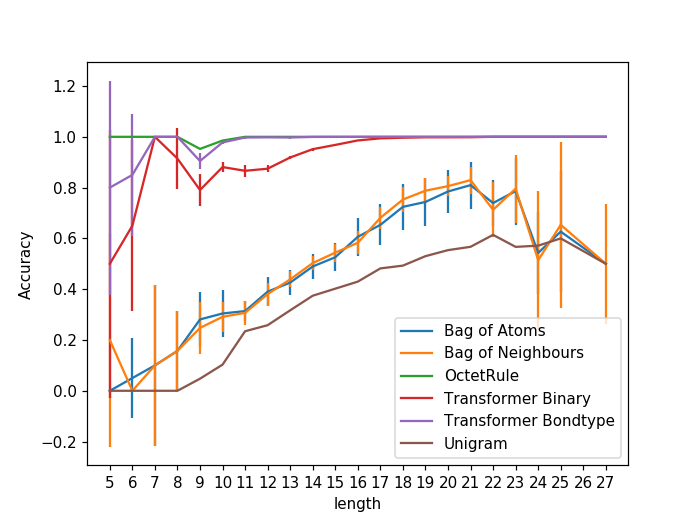

(4, 28)

In [10]:
fig, ax = plt.subplots()
plt.ylabel('Accuracy')

for key, group in results_df['accuracy'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax)
    
plt.xticks(np.arange(5,28, 1.0))
plt.xlim([4, 28])

<IPython.core.display.Javascript object>


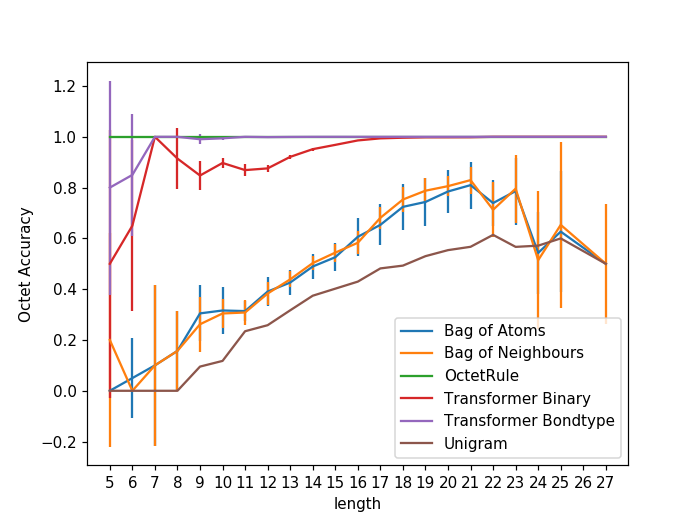

(4, 28)

In [13]:
fig, ax = plt.subplots()
plt.ylabel('Octet Accuracy')

for key, group in results_df['accuracy_octet'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax)
    
plt.xticks(np.arange(5,28, 1.0))
plt.xlim([4, 28])

<IPython.core.display.Javascript object>


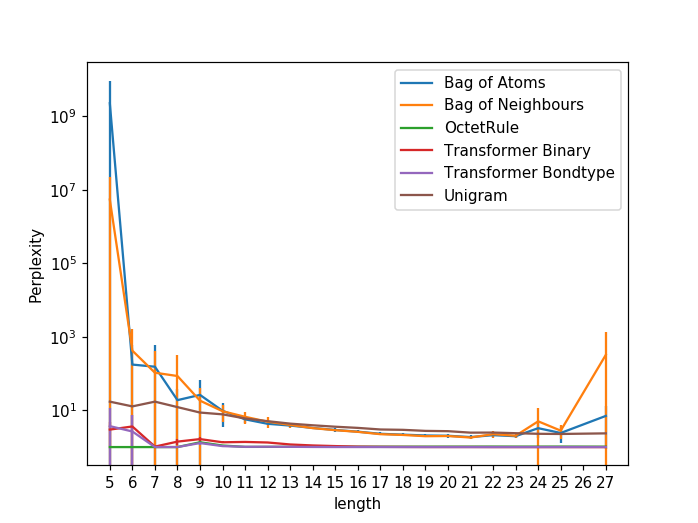

In [11]:
fig, ax = plt.subplots()
plt.ylabel('Perplexity')

for key, group in results_df['pp'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax)
    
plt.xticks(np.arange(5,28, 1.0))
plt.xlim([4, 28])
plt.yscale('log')

# F1

In [8]:
results_df = df.groupby(['num_masks','model_id', 'model_name_short']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'num_masks']).agg(['mean','std'])
results_df

KeyError: 'model_name_short'

<IPython.core.display.Javascript object>


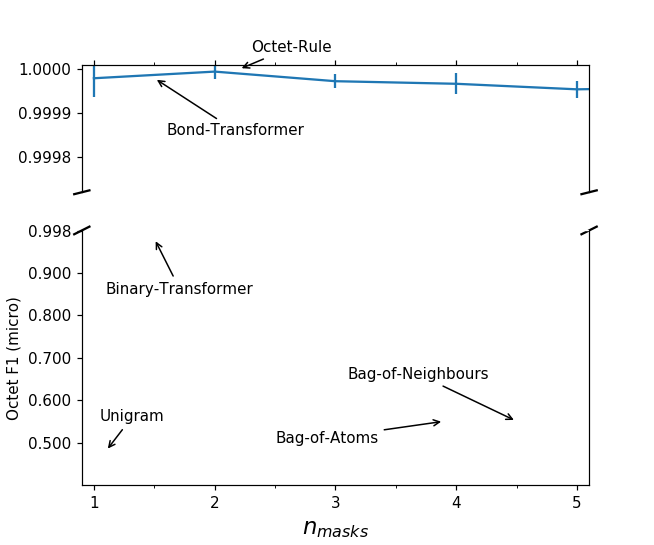

/zhome/9e/8/130993/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [6]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet F1 (micro)')
ax2.annotate('Unigram', xy=(1.1,0.48), xytext=(1.05,0.55),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(3.9,0.55), xytext=(2.5,0.5),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbours', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(1.5,0.98), xytext=(1.1,0.85),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule', xy=(2.2,1), xytext=(2.3,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(1.5,0.99998), xytext=(1.6,0.99985),arrowprops={'arrowstyle':'->'})


colors = {'Unigram':'C5', 
         'Bag-of-Atoms':'C0',
         'Bag-of-Neighbours':'C1',
         'Transformer Binary':'C3',
         'Transformer Bondtype':'w',
         'OctetRule':'w'}

for key, group in results_df['f1'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.99972, 1.00001])
ax2.set_ylim([0.4, 0.999])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.set_xlim([0.9, 5.1])
ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.998])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
plt.savefig('f1_micro_vs_nmask.pdf')

In [6]:
results_df = df[df['num_masks']==1].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
results_df

f1          
                                 mean       std
model_name_short     length                    
Bag-of-Atoms         5       0.300000  0.483046
                     6       0.000000  0.000000
                     7       0.100000  0.316228
                     8       0.142857  0.067344
                     9       0.376190  0.091045
                     10      0.341176  0.035888
                     11      0.324828  0.023990
                     12      0.418318  0.015184
                     13      0.462312  0.011811
                     14      0.510339  0.020437
                     15      0.541580  0.014381
                     16      0.588790  0.026177
                     17      0.670164  0.029761
                     18      0.739095  0.016435
                     19      0.765515  0.036130
                     20      0.839959  0.013244
                     21      0.824252  0.028682
                     22      0.798101  0.009172
                     23      0.827037  0.065932
                     24      0.428571  0.000000
                     25      0.633333  0.245955
                     27      0.500000  0.000000
Bag-of-Neighbours    5       0.200000  0.421637
                     6       0.100000  0.210819
                     7       0.300000  0.483046
                     8       0.157143  0.045175
                     9       0.385714  0.065253
                     10      0.339706  0.039490
                     11      0.324138  0.024111
                     12      0.419820  0.018392
...                               ...       ...
Transformer Bondtype 19      1.000000  0.000000
                     20      1.000000  0.000000
                     21      1.000000  0.000000
                     22      1.000000  0.000000
                     23      1.000000  0.000000
                     24      1.000000  0.000000
                     25      1.000000  0.000000
                     27      1.000000  0.000000
Unigram              5       0.000000       NaN
                     6       0.000000       NaN
                     7       0.000000       NaN
                     8       0.000000       NaN
                     9       0.095238       NaN
                     10      0.117647       NaN
                     11      0.234483       NaN
                     12      0.258258       NaN
                     13      0.316817       NaN
                     14      0.374332       NaN
                     15      0.402084       NaN
                     16      0.429844       NaN
                     17      0.481829       NaN
                     18      0.492847       NaN
                     19      0.530062       NaN
                     20      0.553804       NaN
                     21      0.566929       NaN
                     22      0.613924       NaN
                     23      0.566667       NaN
                     24      0.571429       NaN
                     25      0.600000       NaN
                     27      0.500000       NaN

[132 rows x 2 columns]

<IPython.core.display.Javascript object>


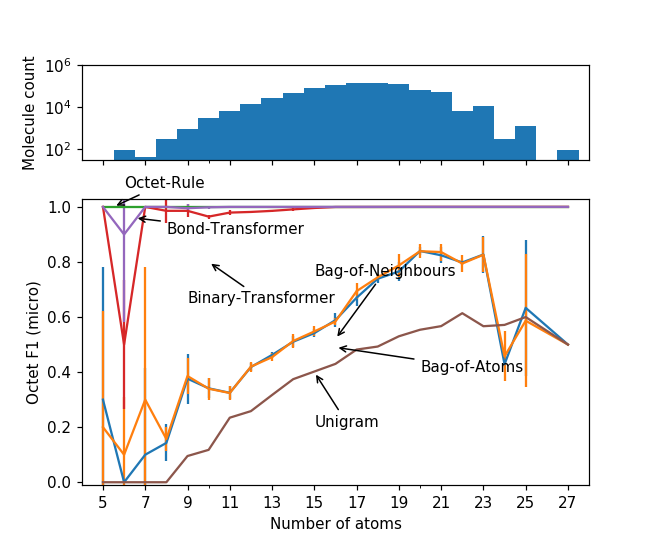

In [7]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax2.set_ylabel('Octet F1 (micro)')
ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_df['f1'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax2)
    
ax2.set_xticks(np.arange(5,28, 2.0))
ax2.set_xlim([4, 28])
ax2.set_ylim([-0.01,1.03])
ax2.get_legend().remove()

ax.hist(df[df['num_masks']==1]['length'], density=False, bins=np.arange(5,28)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e2,1e4,1e6])
ax2.set_xlabel('Number of atoms')
plt.savefig('f1_micro_vs_length.pdf')

<IPython.core.display.Javascript object>


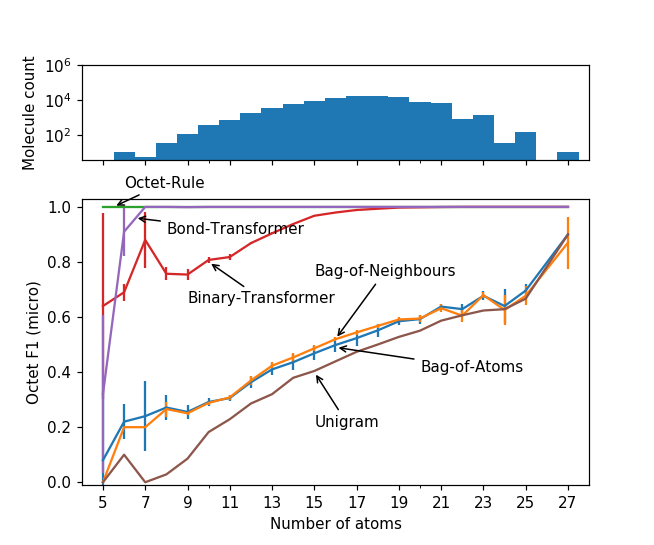

In [17]:
results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax2.set_ylabel('Octet F1 (micro)')
ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_df['f1'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax2)
    
ax2.set_xticks(np.arange(5,28, 2.0))
ax2.set_xlim([4, 28])
ax2.set_ylim([-0.01,1.03])
ax2.get_legend().remove()

ax.hist(df[(df['num_masks']==5) & (df['model_name']=='Unigram')]['length'], density=False, bins=np.arange(5,28)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e2,1e4,1e6])
ax2.set_xlabel('Number of atoms')
plt.savefig('f1_micro_vs_length_5.pdf')

In [20]:
df['model_name_short'].unique()

array(['Unigram', 'OctetRule', 'Bag-of-Neighbours', 'Bag-of-Atoms',
       'Transformer Binary', 'Transformer Bondtype'], dtype=object)

<IPython.core.display.Javascript object>


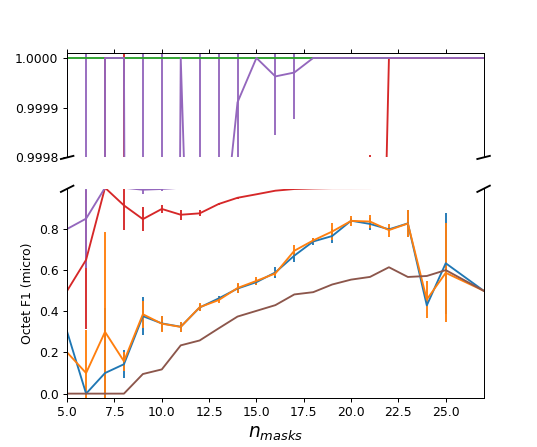

Text(0.5, 0, '$n_{masks}$')

In [34]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet F1 (micro)')
ax2.annotate('Unigram', xy=(1.1,0.48), xytext=(1.05,0.55),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Atoms', xy=(3.9,0.55), xytext=(2.5,0.5),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbours', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(1.5,0.98), xytext=(1.1,0.85),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule', xy=(2.2,1), xytext=(2.3,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(1.5,0.99992), xytext=(1.6,0.99985),arrowprops={'arrowstyle':'->'})

for key, group in results_df['f1'].reset_index().groupby('model_name_short'):

    group.plot('length','mean',yerr='std', label=key, ax=ax)
    group.plot('length','mean',yerr='std', label=key, ax=ax2)

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.9998, 1.00001])
ax2.set_ylim([-0.02, 0.995])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.99])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
#plt.savefig('f1_micro_vs_nmask.pdf')

In [9]:
df2 = pd.read_sql_query("""select atom as target, prediction, model_name, length 
                          from predictions, models, molecules, atoms
                          where predictions.model_id=models.model_id 
                          and predictions.molecule_id=molecules.molecule_id
                          and atoms.atom_id = predictions.target 
                          and num_masks=1
                          and predictions.target!=prediction
                          and model_name not like '%Bin%'
                          """, conn)

<IPython.core.display.Javascript object>


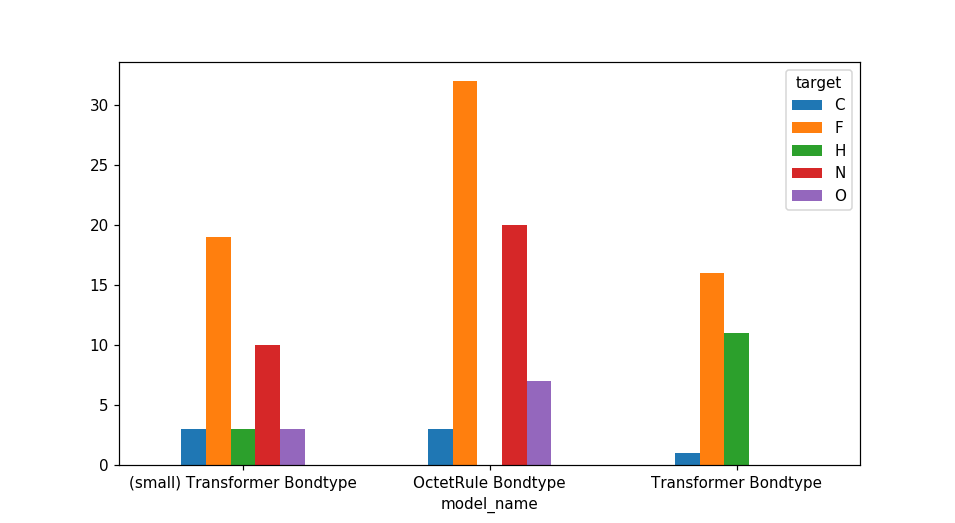

In [10]:
df2.groupby(['model_name','target'])['prediction'].count().unstack().plot.bar(rot=0)

<IPython.core.display.Javascript object>


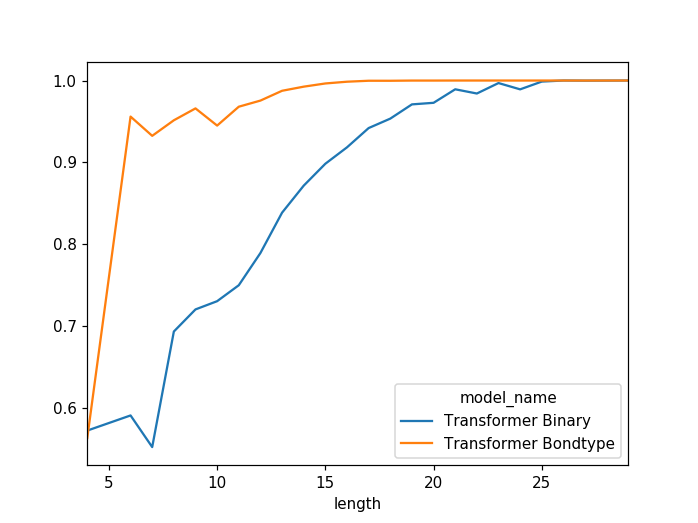

In [10]:
df.groupby(['length','model_name'])['accuracy'].mean().unstack().plot()

<IPython.core.display.Javascript object>


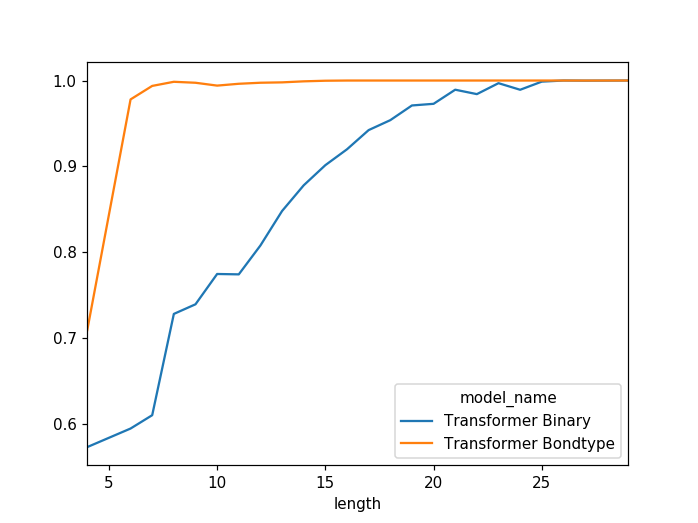

In [11]:
df.groupby(['length','model_name'])['accuracy_octet'].mean().unstack().plot()

In [61]:
df2 = pd.read_sql_query("""select count(*) as c ,atom as target, length 
                          from predictions, molecules, atoms
                          where 
                          predictions.molecule_id=molecules.molecule_id
                          and atoms.atom_id = predictions.target 
                          and model_id=1
                          and num_masks=1
                          group by target, length
                          """, conn)

<IPython.core.display.Javascript object>


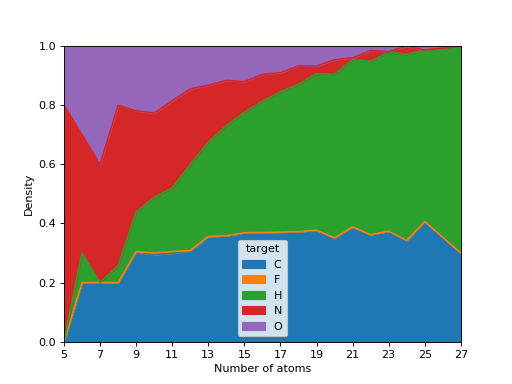

In [63]:
df3= df2.pivot(index='length', columns='target', values='c')
df3.div(df3.sum(axis=1), axis=0).plot.area()
plt.ylabel('Density')
plt.xlabel('Number of atoms')
plt.ylim([0,1])
plt.xticks(np.arange(5,28,2))
plt.savefig('distribution_length_unique.pdf')

<IPython.core.display.Javascript object>


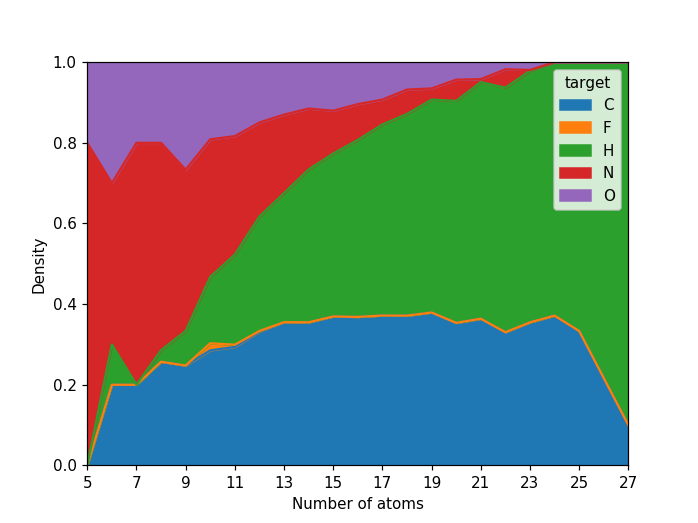

In [43]:
df3= df2.pivot(index='length', columns='target', values='c')
df3.div(df3.sum(axis=1), axis=0).plot.area()
plt.ylabel('Density')
plt.xlabel('Number of atoms')
plt.ylim([0,1])
plt.xticks(np.arange(5,28,2))
plt.savefig('fdistribution_length_5.pdf')

In [ ]:
plt.stackplot(df2['length'], )

In [8]:
conn = sqlite3.connect("data/results.db")



df = pd.read_sql_query(f"""select
                             
                    prediction,
                    target,num_masks, length 
                          from predictions, molecules
                          where  predictions.molecule_id=molecules.molecule_id and model_id=16 and num_masks=1
                           """, conn)
    

In [9]:
#int2atom = {0:'H',1:'C',2:'O',3:'N',4:'F'}
#df['target'] = df['target'].apply(lambda x:int2atom[x])
#df['prediction'] = df['prediction'].apply(lambda x:int2atom[x])
df.head()

,prediction,target,num_masks,length
0,1,1,1,14
1,1,1,1,14
2,1,1,1,14
3,0,0,1,14
4,3,3,1,14


<IPython.core.display.Javascript object>


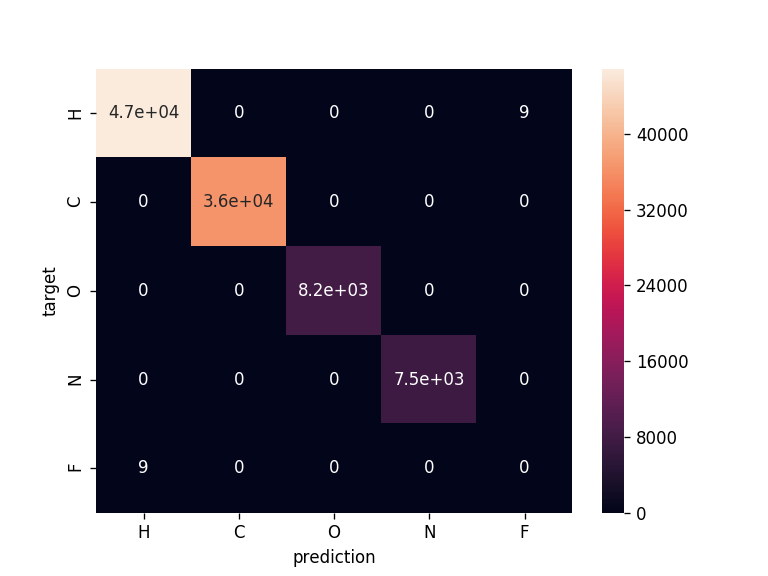

Text(50.722222222222214, 0.5, 'target')

In [11]:
import seaborn as sn
ax= sn.heatmap(confusion_matrix(df['target'],df['prediction']), annot=True)
ax.xaxis.set_ticklabels(['H','C','O','N','F'])
ax.yaxis.set_ticklabels(['H','C','O','N','F'])
ax.set_xlabel('prediction')
ax.set_ylabel('target')

In [13]:
confusion_matrix(df['target'],df['prediction'])

array([[1013851,       0,       3,       0,      17],
       [      0,  753592,       0,       0,       0],
       [      0,       0,  179110,      11,       0],
       [      0,      20,       0,  161372,       0],
       [    459,       0,       0,       0,       0]])